In [ ]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ARIMA_LSTM/data_modified_19-04.csv")

In [ ]:
data["datetime"] = pd.to_datetime(data["datetime"])

In [ ]:
data.dtypes

Unnamed: 0             int64
item                   int64
datetime      datetime64[ns]
q_sold                 int64
avg_neu              float64
avg_neg              float64
avg_pos              float64
avg_rate             float64
label                float64
dtype: object

In [ ]:
# USE_SENTIMENT = False
# item in X: q_sold + 3 sentiment. [7x4]
# previous: 7x1

def rolling_window(arr, use_in_train_arr, dates, window):
  X = []
  Y = []
  mydate = []
  for i, (item, use_in_train, date) in enumerate(zip(arr, use_in_train_arr, dates)):
    if i<window: continue
    if not use_in_train: continue
    X.append(arr[i-window:i])
    Y.append(item[0])
    mydate.append(date)
  X = np.array(X)
  Y = np.array(Y)
  mydate = np.array(mydate)
  return X, Y, mydate

In [ ]:
# create train and test set
TEST_START_DATE = "2023-04-10"
WINDOW = 7

X_data = []
Y_data = []
dates_data = []

for item_id in data["item"].unique():
  x = data[data["item"] == item_id] # data of 1 item
  x = x.set_index("datetime")
  new_date_range = pd.date_range(start="2023-03-04", end="2023-04-13", freq="D")
  x = x.reindex(new_date_range, fill_value=None)
  fill_zero_columns = ["avg_neu", "avg_pos", "avg_neg", "avg_rate"]
  fill_avg_columns = ["q_sold"]
  x["use_in_train"] = x["q_sold"].map(lambda y: y == y)
  for col in fill_zero_columns:
    for i, item in enumerate(x[col]):
      if item != item:
        x[col][i] = 0
  for col in fill_avg_columns:
    for i, item in enumerate(x[col]):
      if item != item:
        x[col][i] = x[col].mean()
  X_item, Y_item, dates_item = rolling_window(x[["q_sold","avg_neu", "avg_pos","avg_neg"]].to_numpy(), x["use_in_train"].to_numpy(), x.index.to_numpy(), WINDOW)
  # X_item, Y_item, dates_item = rolling_window(x[["q_sold"]].to_numpy(), x["use_in_train"].to_numpy(), x.index.to_numpy(), WINDOW)
  X_data.append(X_item)
  Y_data.append(Y_item)
  dates_data.append(dates_item)

X_data = np.concatenate(X_data)
Y_data = np.concatenate(Y_data)
dates_data = np.concatenate(dates_data)
X_data


array([[[1.90000000e+01, 1.86105057e-01, 7.24950003e-01, 8.89449358e-02],
        [2.30000000e+01, 1.82642591e-01, 7.30066784e-01, 8.72906213e-02],
        [1.30000000e+01, 1.81515810e-01, 7.31731662e-01, 8.67525250e-02],
        ...,
        [2.10000000e+01, 1.80404189e-01, 7.33374764e-01, 8.62210430e-02],
        [1.70000000e+01, 1.78630934e-01, 7.34059382e-01, 8.73096803e-02],
        [1.20000000e+01, 1.78630934e-01, 7.34059382e-01, 8.73096803e-02]],

       [[2.30000000e+01, 1.82642591e-01, 7.30066784e-01, 8.72906213e-02],
        [1.30000000e+01, 1.81515810e-01, 7.31731662e-01, 8.67525250e-02],
        [1.50000000e+01, 1.81515810e-01, 7.31731662e-01, 8.67525250e-02],
        ...,
        [1.70000000e+01, 1.78630934e-01, 7.34059382e-01, 8.73096803e-02],
        [1.20000000e+01, 1.78630934e-01, 7.34059382e-01, 8.73096803e-02],
        [1.60000000e+01, 1.78630934e-01, 7.34059382e-01, 8.73096803e-02]],

       [[1.30000000e+01, 1.81515810e-01, 7.31731662e-01, 8.67525250e-02],
        

In [ ]:
X_data.shape

(9167, 7, 4)

In [ ]:
Y_data.shape

(9167,)

In [ ]:
dates_data.shape

(9167,)

In [ ]:

# split train test
def train_test_split(X, Y, dates, start_test_date):
  test_indices = dates >= start_test_date
  train_indices = dates < start_test_date
  X_train = X[train_indices]
  Y_train = Y[train_indices]
  dates_train = dates[train_indices]

  X_test = X[test_indices]
  Y_test = Y[test_indices]
  dates_test = dates[test_indices]
  return X_train, Y_train, dates_train, X_test, Y_test, dates_test

In [ ]:
start_test_date = pd.to_datetime("2023-04-10")
X_train, Y_train, dates_train, X_test, Y_test, dates_test = train_test_split(X_data, Y_data, dates_data, start_test_date)
print(X_train.shape)
print(X_test.shape)

(8157, 7, 4)
(1010, 7, 4)


In [ ]:
print(np.max(dates_train))
print(np.min(dates_train))
print(np.max(dates_test))
print(np.min(dates_test))

2023-04-09T00:00:00.000000000
2023-03-11T00:00:00.000000000
2023-04-13T00:00:00.000000000
2023-04-10T00:00:00.000000000


In [ ]:
np.max(X_train)

250.0

In [ ]:
np.max(X_train, axis=0) # 7

array([[214.        ,   0.99856949,   0.99975199,   0.58121252],
       [214.        ,   0.99856949,   0.99975199,   0.58121252],
       [214.        ,   0.99856949,   0.99975199,   0.58121252],
       [250.        ,   0.99856949,   0.99975199,   0.58121252],
       [250.        ,   0.99856949,   0.99975199,   0.58121252],
       [250.        ,   0.99856949,   0.99975199,   0.58121252],
       [250.        ,   0.99856949,   0.99975199,   0.58121252]])

In [ ]:
np.max(X_train, axis=1) # qsold + sentiment

array([[23.        ,  0.18610506,  0.73405938,  0.08894494],
       [23.        ,  0.18264259,  0.73405938,  0.08730968],
       [21.        ,  0.18151581,  0.73565877,  0.08730968],
       ...,
       [13.        ,  0.04222291,  0.88759394,  0.07140002],
       [13.        ,  0.04222291,  0.88759394,  0.07140002],
       [13.        ,  0.04189889,  0.88759394,  0.07085257]])

In [ ]:
np.max(X_train, axis=2) # qsold

array([[19., 23., 13., ..., 21., 17., 12.],
       [23., 13., 15., ..., 17., 12., 16.],
       [13., 15., 21., ..., 12., 16., 14.],
       ...,
       [ 7., 11.,  7., ..., 13.,  9.,  9.],
       [11.,  7.,  9., ...,  9.,  9., 12.],
       [ 7.,  9., 13., ...,  9., 12., 11.]])

In [ ]:
X_train

array([[[19.        ,  0.18610506,  0.72495   ,  0.08894494],
        [23.        ,  0.18264259,  0.73006678,  0.08729062],
        [13.        ,  0.18151581,  0.73173166,  0.08675253],
        ...,
        [21.        ,  0.18040419,  0.73337476,  0.08622104],
        [17.        ,  0.17863093,  0.73405938,  0.08730968],
        [12.        ,  0.17863093,  0.73405938,  0.08730968]],

       [[23.        ,  0.18264259,  0.73006678,  0.08729062],
        [13.        ,  0.18151581,  0.73173166,  0.08675253],
        [15.        ,  0.18151581,  0.73173166,  0.08675253],
        ...,
        [17.        ,  0.17863093,  0.73405938,  0.08730968],
        [12.        ,  0.17863093,  0.73405938,  0.08730968],
        [16.        ,  0.17863093,  0.73405938,  0.08730968]],

       [[13.        ,  0.18151581,  0.73173166,  0.08675253],
        [15.        ,  0.18151581,  0.73173166,  0.08675253],
        [21.        ,  0.18040419,  0.73337476,  0.08622104],
        ...,
        [12.        ,  0.17

In [ ]:
X_train[2]

array([[13.        ,  0.18151581,  0.73173166,  0.08675253],
       [15.        ,  0.18151581,  0.73173166,  0.08675253],
       [21.        ,  0.18040419,  0.73337476,  0.08622104],
       [17.        ,  0.17863093,  0.73405938,  0.08730968],
       [12.        ,  0.17863093,  0.73405938,  0.08730968],
       [16.        ,  0.17863093,  0.73405938,  0.08730968],
       [14.        ,  0.1775566 ,  0.73565877,  0.08678463]])

In [ ]:
max_row_index = np.argmax(X_train)
max_row_index

209856

In [ ]:
max_row_index = np.argmax(X_train,axis=1)
max_row_index

array([[1, 0, 5, 0],
       [0, 0, 4, 4],
       [2, 0, 6, 3],
       ...,
       [4, 0, 5, 0],
       [3, 0, 4, 0],
       [2, 0, 3, 0]])

In [ ]:
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow_decision_forests

In [ ]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

In [ ]:
clf = LinearRegression(n_jobs=-1)
DTRmodel = DecisionTreeRegressor(max_depth=3, random_state=0)
RFRmodel = RandomForestRegressor(max_depth=3, random_state=0)

In [ ]:
model_1 = tfdf.keras.RandomForestModel(verbose=2)

Use 2 thread(s) for training
Use /tmp/tmpk7kq3uub as temporary training directory


In [ ]:
model = XGBRegressor()

# **CNN**

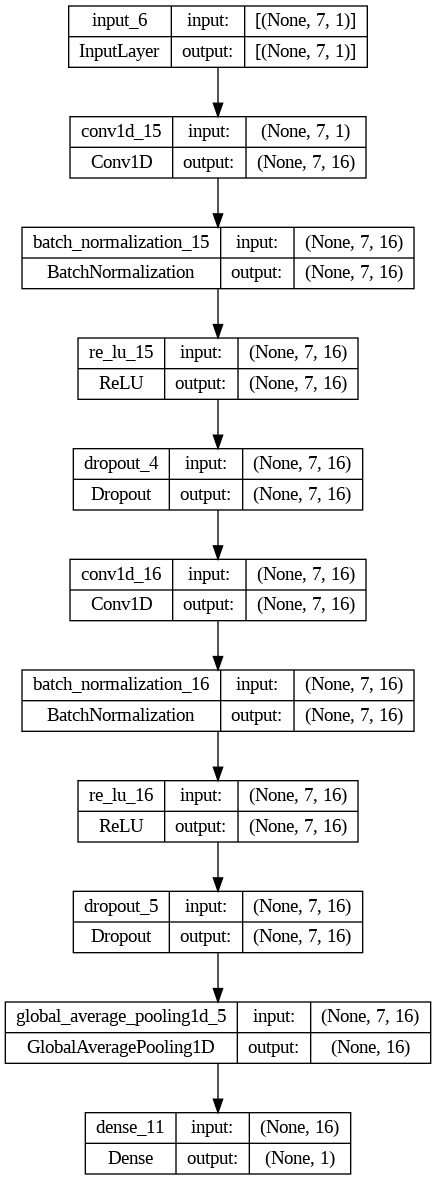

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

NUM_FILTERS = 16
DROPOUT_RATE = 0.3
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    layer = layers.Dense(
    units=64,
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)
)

    conv1 = keras.layers.Conv1D(filters=NUM_FILTERS, kernel_size=7, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv1 = keras.layers.Dropout(DROPOUT_RATE)(conv1)

    conv2 = keras.layers.Conv1D(filters=NUM_FILTERS, kernel_size=7, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.Dropout(DROPOUT_RATE)(conv2)

    conv3 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv2)

    output_layer = keras.layers.Dense(1, activation=None)(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train[0].shape)
# model_1 = make_model(input_shape=X_train[0].shape)
# clf = make_model(input_shape=X_train[0].shape)
# DTRmodel = make_model(input_shape=X_train[0].shape)
# RFRmodel = make_model(input_shape=X_train[0].shape)


# keras.utils.plot_model(model_1, show_shapes=True)
keras.utils.plot_model(model, show_shapes=True)
# keras.utils.plot_model(DTRmodel , show_shapes=True)
# keras.utils.plot_model(RFRmodel , show_shapes=True)

In [ ]:
import tensorflow as tf
from keras.metrics import Metric

class DailySalesMetric(Metric):
    def __init__(self, name='daily_sales_metric', **kwargs):
        super(DailySalesMetric, self).__init__(name=name, **kwargs)
        self.total_sales = self.add_weight(name='total_sales', initializer='zeros')
        self.total_days = self.add_weight(name='total_days', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Calculate the total sales and total days
        self.total_sales.assign_add(tf.reduce_sum(y_true))
        self.total_days.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        # Calculate the average daily sales
        average_daily_sales = self.total_sales / self.total_days
        return average_daily_sales

    def reset_states(self):
        # Reset the accumulated values
        self.total_sales.assign(0.0)
        self.total_days.assign(0.0)

In [ ]:
import tensorflow as tf
from keras import backend as K

def r1_metric(y_true, y_pred):
    residual = y_true - y_pred
    ss_res = K.sum(K.square(residual))
    ss_total = K.sum(K.square(y_true - K.mean(y_true)))

    # Calculate the R-squared
    r2 = 1 - ss_res / ss_total

    # Calculate the custom metric (r1)
    r1 = r2 - 0.5 * K.mean(K.cast(residual > 0, dtype=tf.float32))

    return r1

In [ ]:
import tensorflow as tf
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.00001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(),
             tf.keras.metrics.MeanSquaredError(),
             tf.keras.metrics.MeanAbsoluteError(),
             keras.metrics.PrecisionAtRecall(recall=0.5, name='r0.5'),
             DailySalesMetric(),
             r1_metric]
)

NORMALIZED_FACTOR = np.max(X_train, axis=0)
print(NORMALIZED_FACTOR.shape)
history = model.fit(
    X_train/NORMALIZED_FACTOR,
    Y_train/NORMALIZED_FACTOR[0,0],
    # X_train,
    # Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test/NORMALIZED_FACTOR, Y_test/NORMALIZED_FACTOR[0,0]),
    # validation_data=(X_test, Y_test),
    verbose=1,
)


(7, 1)
Epoch 1/500
255/255 [==============================] - 3s 6ms/step - loss: 0.1467 - root_mean_squared_error: 0.3021 - mean_squared_error: 0.0913 - mean_absolute_error: 0.1467 - r0.5: 1.0000 - daily_sales_metric: 0.0512 - r1_metric: -38.1745 - val_loss: 0.0385 - val_root_mean_squared_error: 0.0809 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0385 - val_r0.5: 1.0000 - val_daily_sales_metric: 0.0542 - val_r1_metric: -0.7248 - lr: 0.0010
Epoch 2/500
255/255 [==============================] - 1s 4ms/step - loss: 0.0894 - root_mean_squared_error: 0.1826 - mean_squared_error: 0.0334 - mean_absolute_error: 0.0894 - r0.5: 1.0000 - daily_sales_metric: 0.0512 - r1_metric: -14.5566 - val_loss: 0.0322 - val_root_mean_squared_error: 0.0617 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0322 - val_r0.5: 1.0000 - val_daily_sales_metric: 0.0542 - val_r1_metric: -0.3877 - lr: 0.0010
Epoch 3/500
255/255 [==============================] - 1s 5ms/step - loss: 0.0618 -

In [ ]:
print(min(history.history['val_loss']) * NORMALIZED_FACTOR[0,0])
print(min(history.history['val_mean_absolute_error'])* NORMALIZED_FACTOR[0,0])
print(min(history.history['val_root_mean_squared_error'])* NORMALIZED_FACTOR[0,0])
print(min(history.history['val_r0.5'])* NORMALIZED_FACTOR[0,0])
print(min(history.history['val_daily_sales_metric'])* NORMALIZED_FACTOR[0,0])
print(min(history.history['val_r1_metric'])* NORMALIZED_FACTOR[0,0])

4.758885625749826
4.758885625749826
12.459909699857235
214.0
11.59801895916462
-155.09918761253357


In [ ]:
print(min(history.history['val_loss']))
print(min(history.history['val_mean_absolute_error']))
print(min(history.history['val_root_mean_squared_error']))

print(min(history.history['val_mean_squared_error']))

4.679074764251709
4.679074764251709
11.942004203796387
142.61146545410156


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(Y_test)
plt.plot(model(X_test))
plt.show()

In [ ]:
NORMALIZED_FACTOR

# **Auto - ARIMA**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import pmdarima as pm
import pandas as pd
import numpy as np
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np


from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [ ]:
# Convert the numpy array to a pandas dataframe
df = pd.DataFrame(X_train.reshape(-1, X_train.shape[-1]),dtype=np.float32)
df

,0,1,2,3
0,19.0,0.186105,0.724950,0.088945
1,23.0,0.182643,0.730067,0.087291
2,13.0,0.181516,0.731732,0.086753
3,15.0,0.181516,0.731732,0.086753
4,21.0,0.180404,0.733375,0.086221
...,...,...,...,...
57094,13.0,0.041835,0.887422,0.070744
57095,9.0,0.041771,0.887594,0.070635
57096,9.0,0.041771,0.887594,0.070635
57097,12.0,0.041771,0.887594,0.070635


In [ ]:
# Add column names
df.columns = ['q_sold', "avg_neu", "avg_pos","avg_neg"]

In [ ]:
df

,q_sold,avg_neu,avg_pos,avg_neg
0,19.0,0.186105,0.724950,0.088945
1,23.0,0.182643,0.730067,0.087291
2,13.0,0.181516,0.731732,0.086753
3,15.0,0.181516,0.731732,0.086753
4,21.0,0.180404,0.733375,0.086221
...,...,...,...,...
57094,13.0,0.041835,0.887422,0.070744
57095,9.0,0.041771,0.887594,0.070635
57096,9.0,0.041771,0.887594,0.070635
57097,12.0,0.041771,0.887594,0.070635


In [ ]:
df_test = pd.DataFrame(X_test.reshape(-1, X_test.shape[-1]),dtype=np.float32)
df_test

,0,1,2,3
0,3.000000,0.186105,0.731061,0.082834
1,3.000000,0.186105,0.731061,0.082834
2,4.000000,0.186105,0.731061,0.082834
3,3.000000,0.186105,0.731061,0.082834
4,6.000000,0.186105,0.731061,0.082834
...,...,...,...,...
7065,7.933333,0.000000,0.000000,0.000000
7066,7.933333,0.000000,0.000000,0.000000
7067,7.933333,0.000000,0.000000,0.000000
7068,7.933333,0.000000,0.000000,0.000000


In [ ]:
df_test.columns = ['q_sold', "avg_neu", "avg_pos","avg_neg"]

In [ ]:
df_test

,q_sold,avg_neu,avg_pos,avg_neg
0,3.000000,0.186105,0.731061,0.082834
1,3.000000,0.186105,0.731061,0.082834
2,4.000000,0.186105,0.731061,0.082834
3,3.000000,0.186105,0.731061,0.082834
4,6.000000,0.186105,0.731061,0.082834
...,...,...,...,...
7065,7.933333,0.000000,0.000000,0.000000
7066,7.933333,0.000000,0.000000,0.000000
7067,7.933333,0.000000,0.000000,0.000000
7068,7.933333,0.000000,0.000000,0.000000


In [ ]:
# X_train[0]

array([[[19.        ,  0.18610506,  0.72495   ,  0.08894494,
          4.44936709],
        [23.        ,  0.18264259,  0.73006678,  0.08729062,
          4.45962733],
        [13.        ,  0.18151581,  0.73173166,  0.08675253,
          4.46296296],
        ...,
        [21.        ,  0.18040419,  0.73337476,  0.08622104,
          4.46625767],
        [17.        ,  0.17863093,  0.73405938,  0.08730968,
          4.45454545],
        [12.        ,  0.17863093,  0.73405938,  0.08730968,
          4.45454545]],

       [[23.        ,  0.18264259,  0.73006678,  0.08729062,
          4.45962733],
        [13.        ,  0.18151581,  0.73173166,  0.08675253,
          4.46296296],
        [15.        ,  0.18151581,  0.73173166,  0.08675253,
          4.46296296],
        ...,
        [17.        ,  0.17863093,  0.73405938,  0.08730968,
          4.45454545],
        [12.        ,  0.17863093,  0.73405938,  0.08730968,
          4.45454545],
        [16.        ,  0.17863093,  0.73405938, 

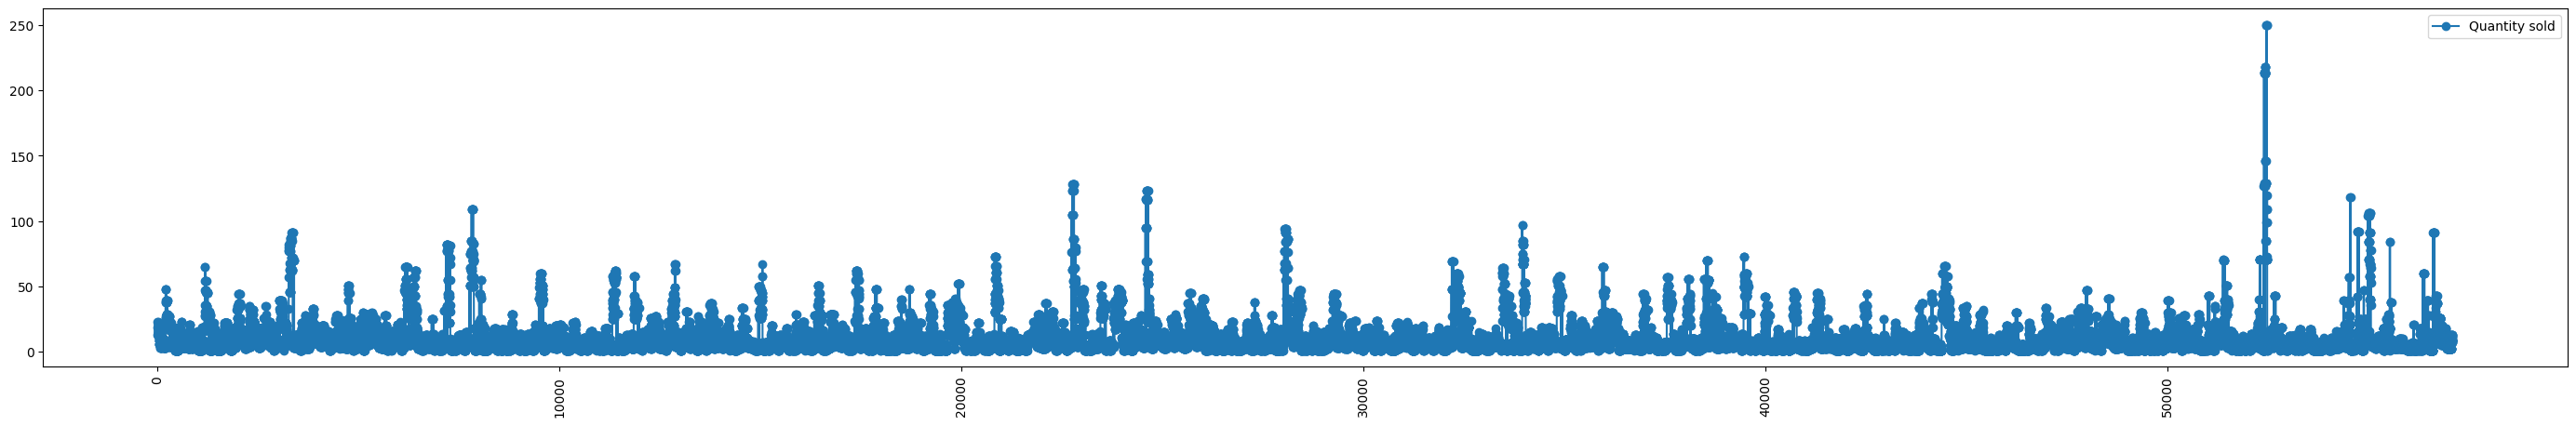

In [ ]:
# Ploting the curve
plt.figure(figsize=(35,5))
#plt.grid()
plt.plot(df["q_sold"], marker='o', label='Quantity sold')
plt.xticks(rotation=90)
plt.legend()
plt.show()

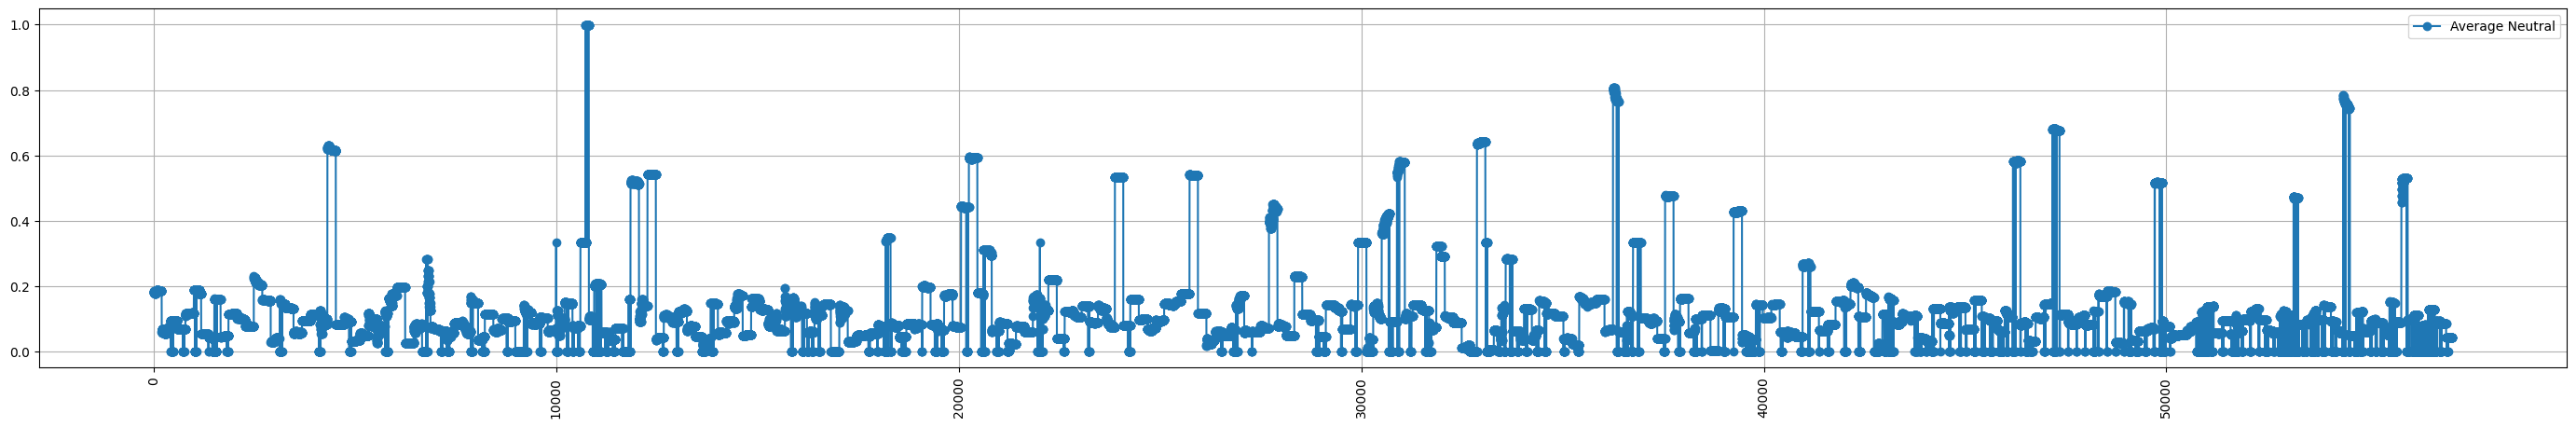

In [ ]:
# Ploting the curve
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(df["avg_neu"], marker='o', label='Average Neutral')
plt.xticks(rotation=90)
plt.legend()
plt.show()

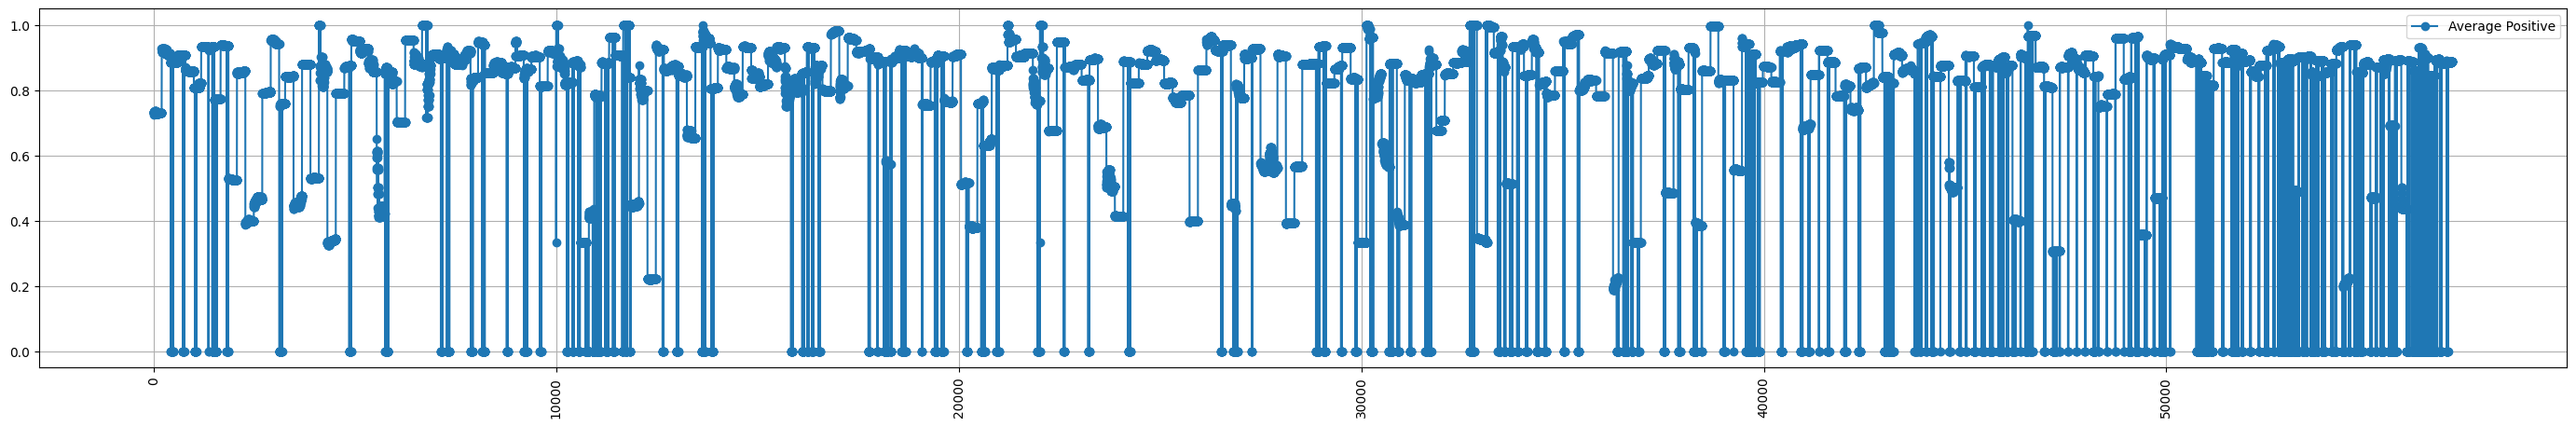

In [ ]:
# Plot first 400 observation
# Ploting the curve
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(df['avg_pos'], marker='o', label='Average Positive')
plt.xticks(rotation=90)
plt.legend()
plt.show()

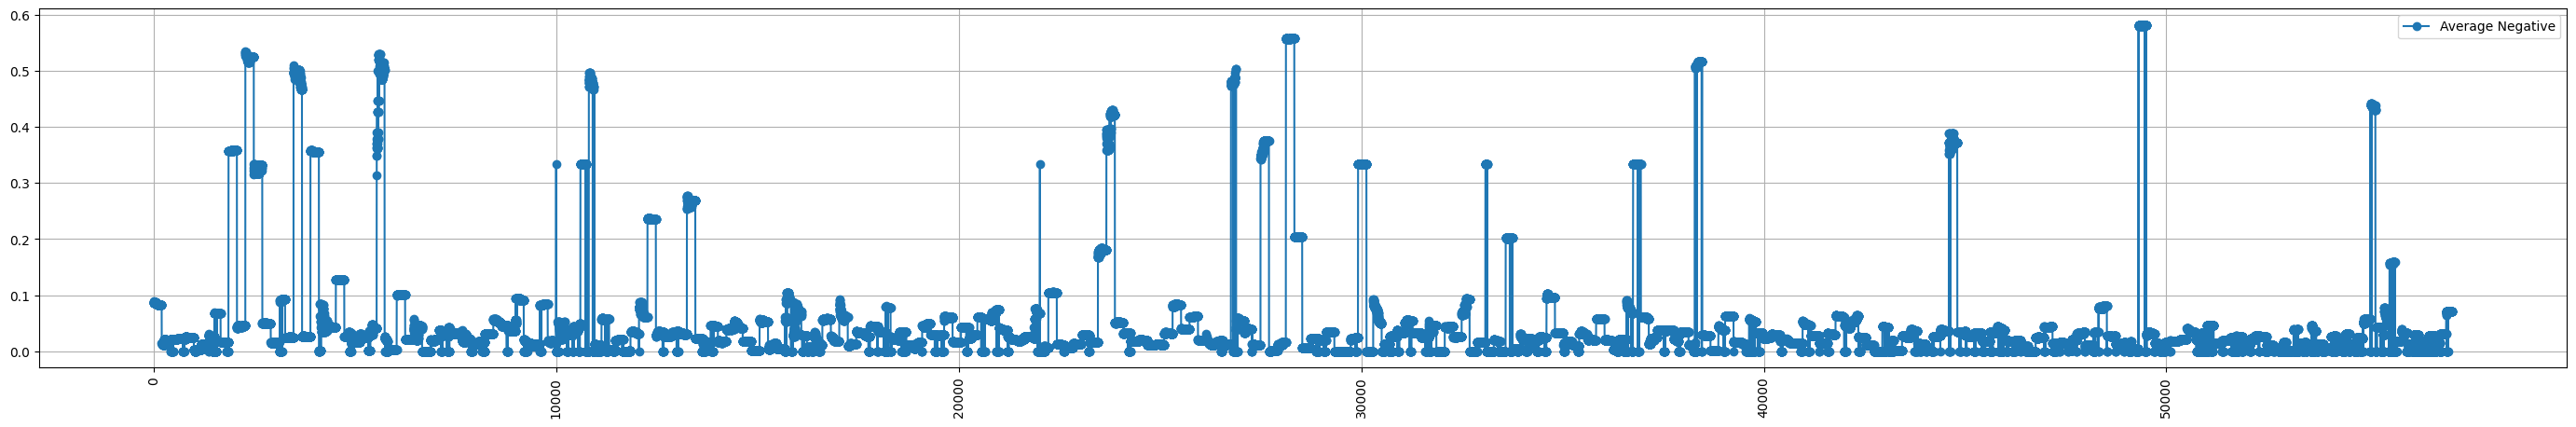

In [ ]:
# Ploting the curve
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(df['avg_neg'], marker='o', label='Average Negative')
plt.xticks(rotation=90)
plt.legend()
plt.show()

## Seasonal Decomposition

In [ ]:
ts_decomposition = seasonal_decompose(x=df['q_sold'], model='additive', period=6)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

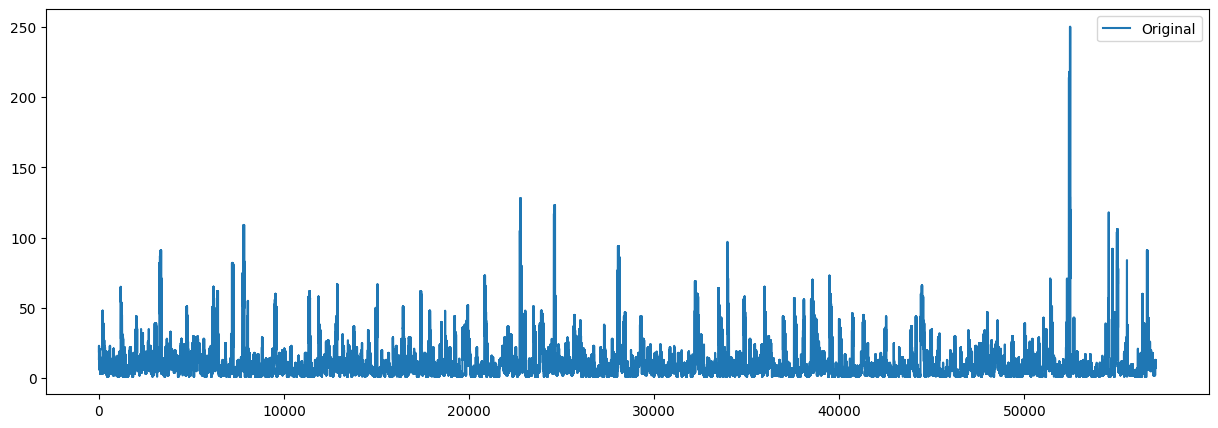

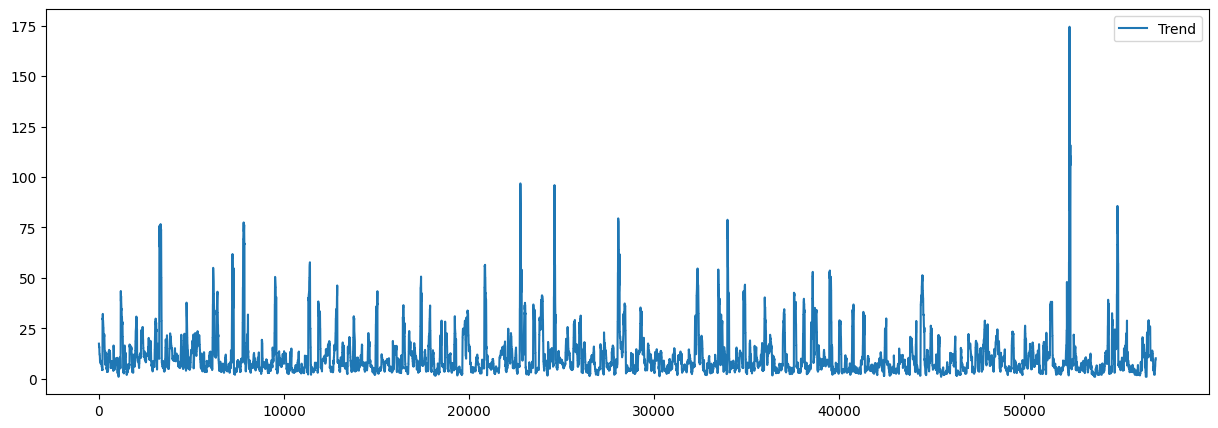

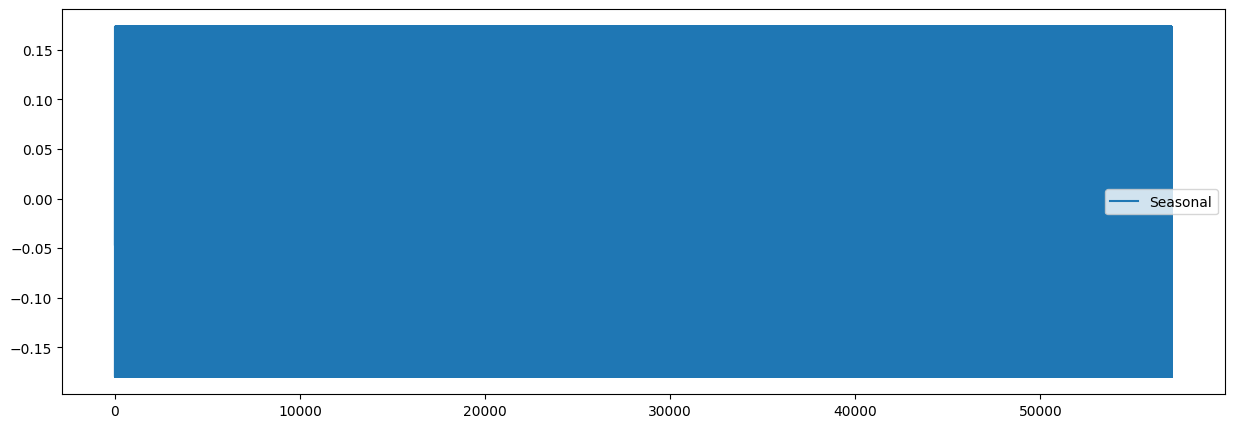

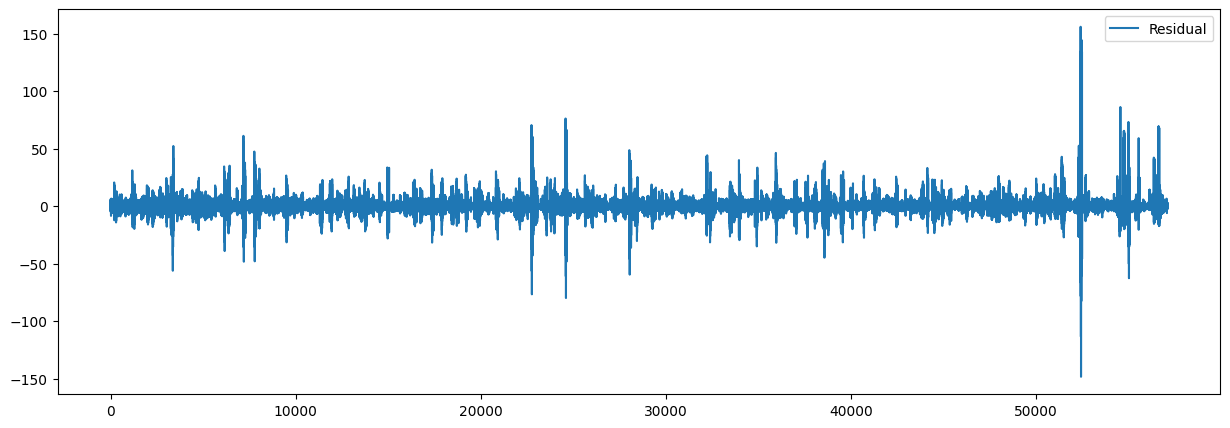

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df['q_sold'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

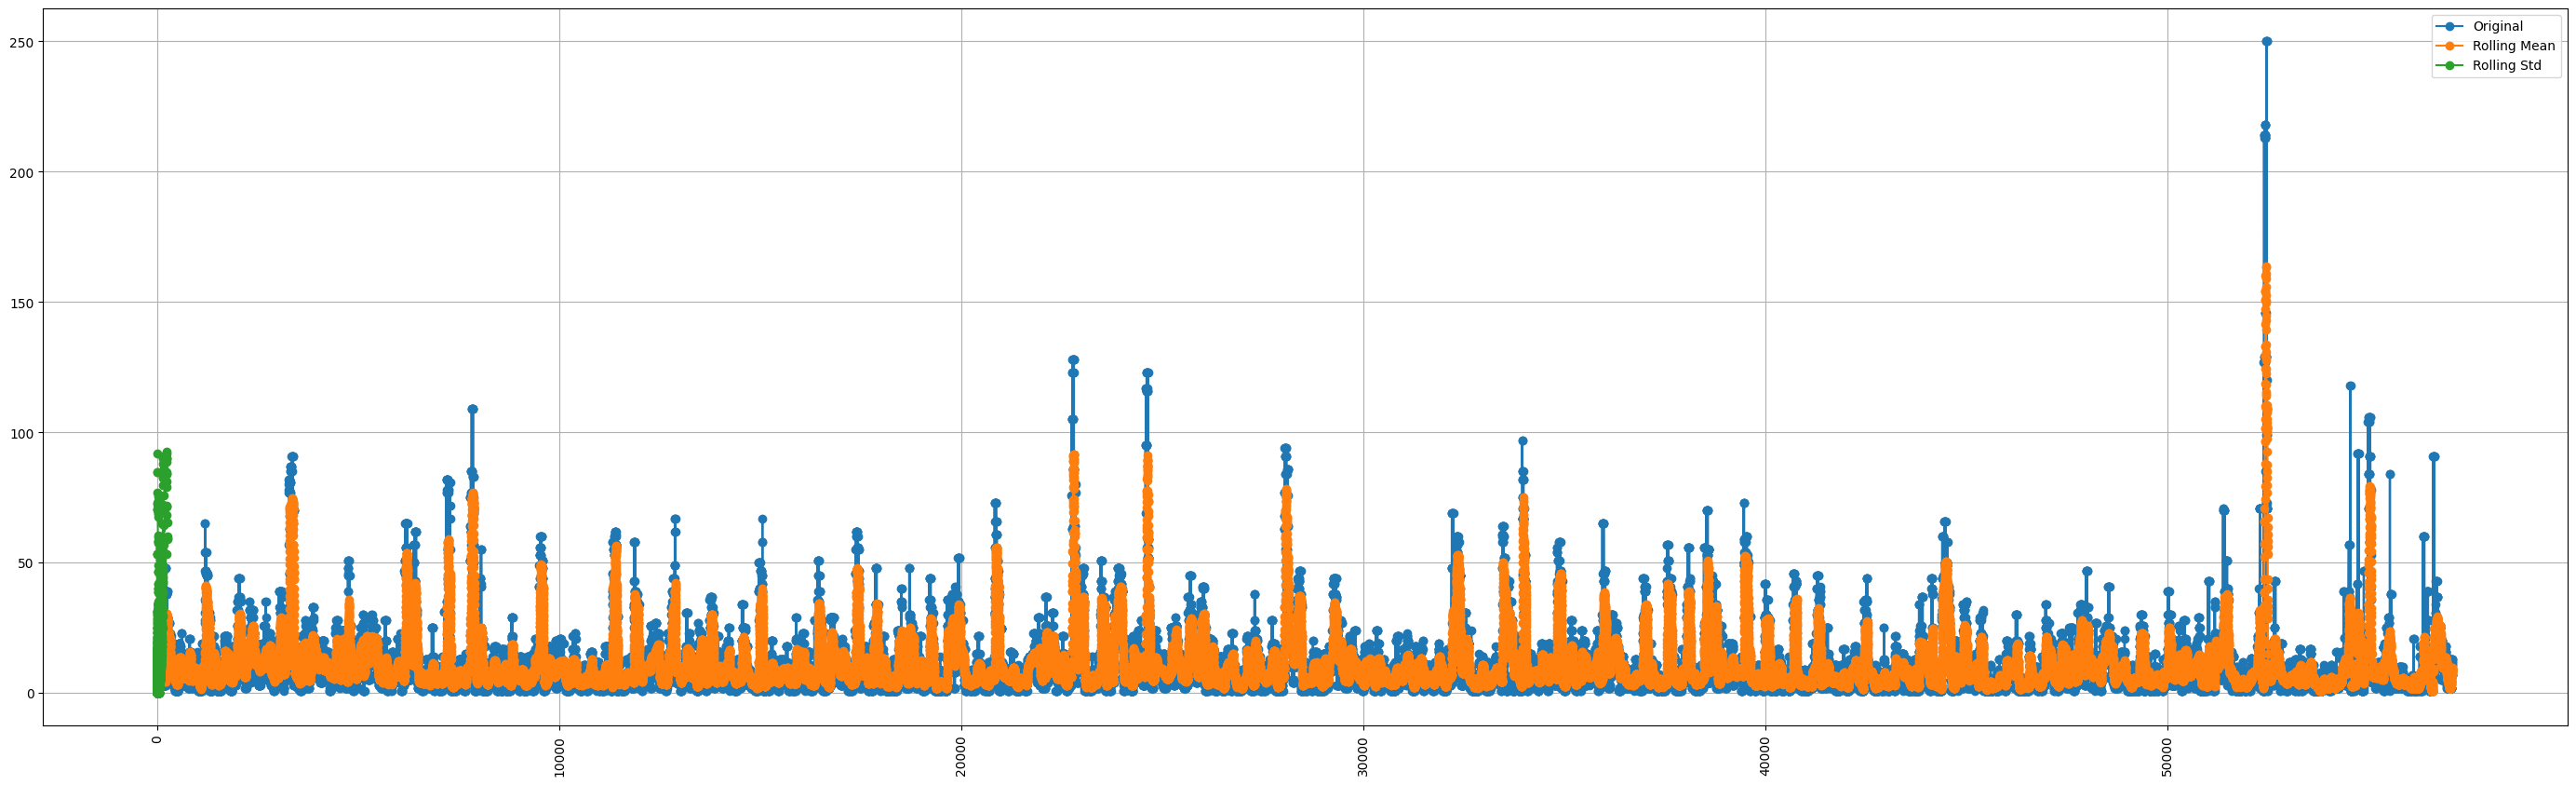

In [ ]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df['q_sold'], marker='o', label='Original')
plt.plot(df['q_sold'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(df['q_sold'], df['q_sold'].rolling(window=25).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

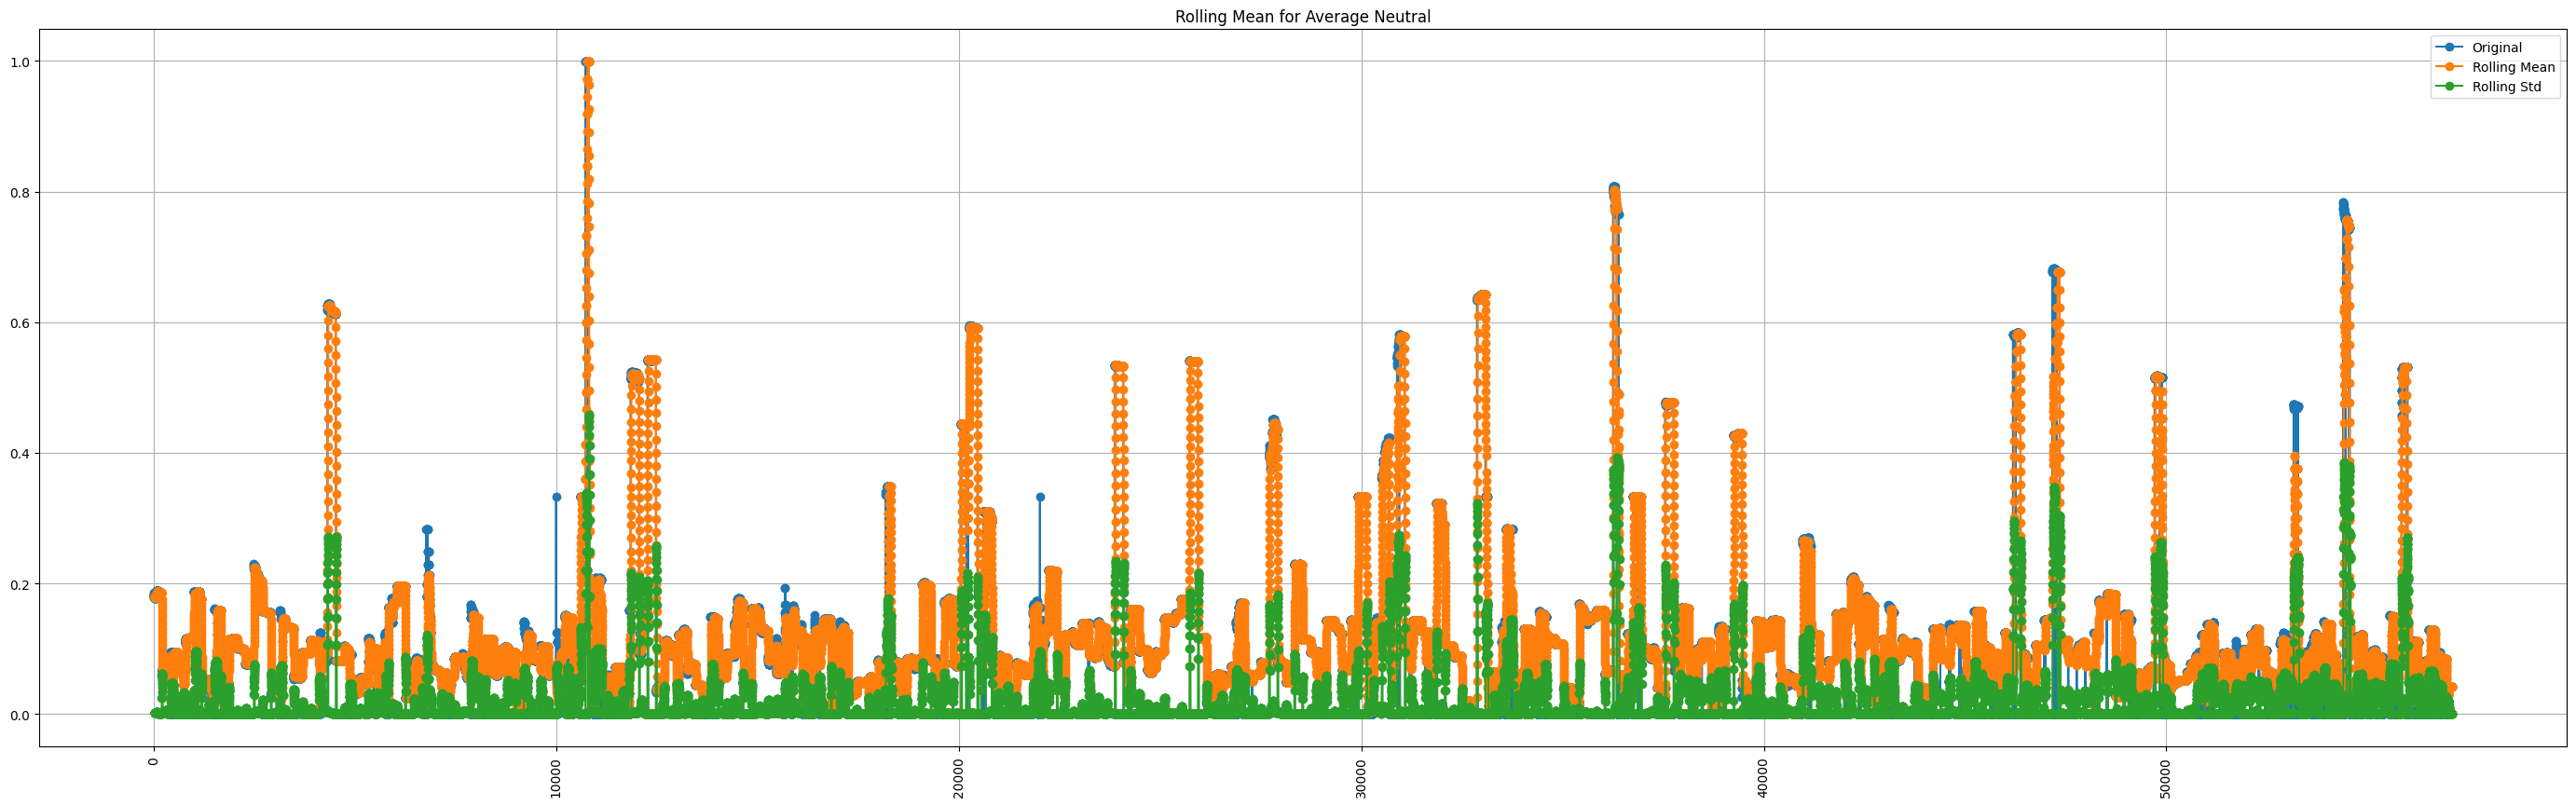

In [ ]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df['avg_neu'], marker='o', label='Original')
plt.plot(df['avg_neu'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(df['avg_neu'].rolling(window=25).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.title("Rolling Mean for Average Neutral")
plt.legend()
plt.show()

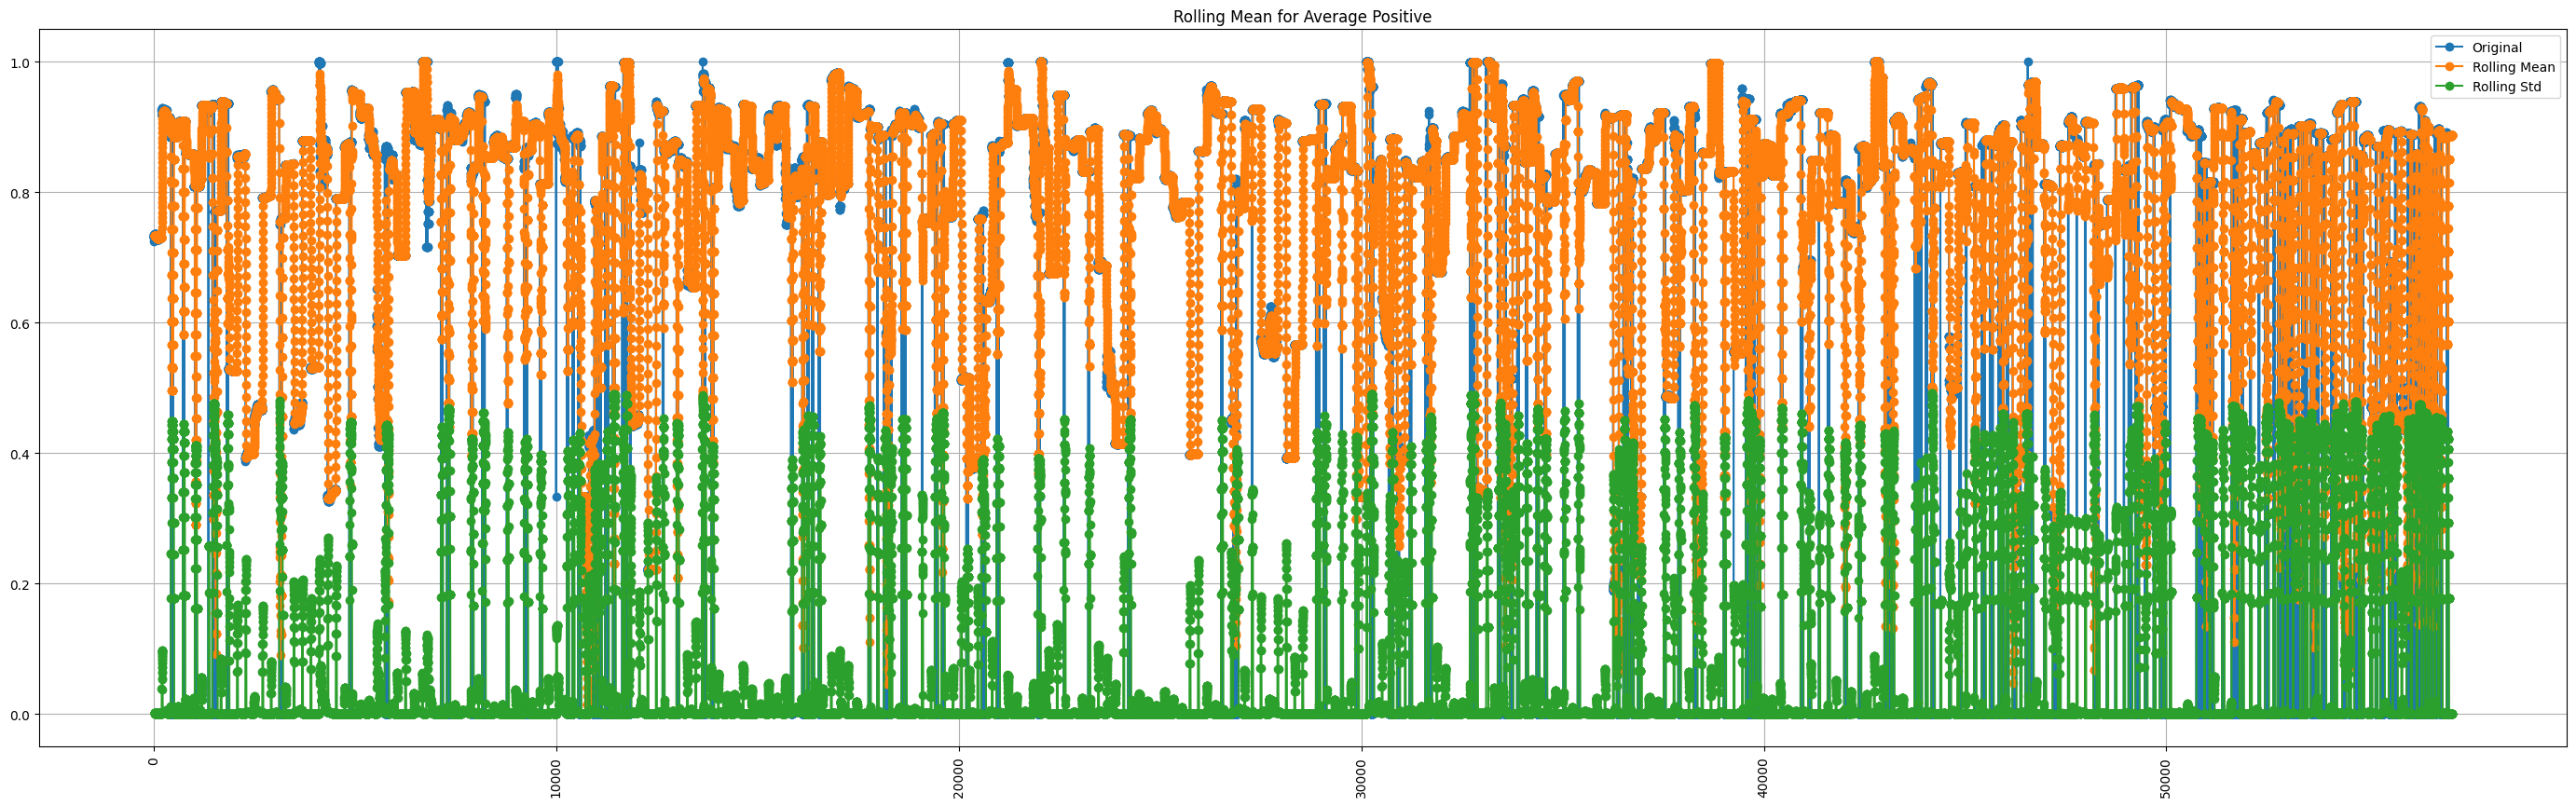

In [ ]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df['avg_pos'], marker='o', label='Original')
plt.plot(df['avg_pos'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(df['avg_pos'].rolling(window=25).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.title("Rolling Mean for Average Positive")
plt.legend()
plt.show()

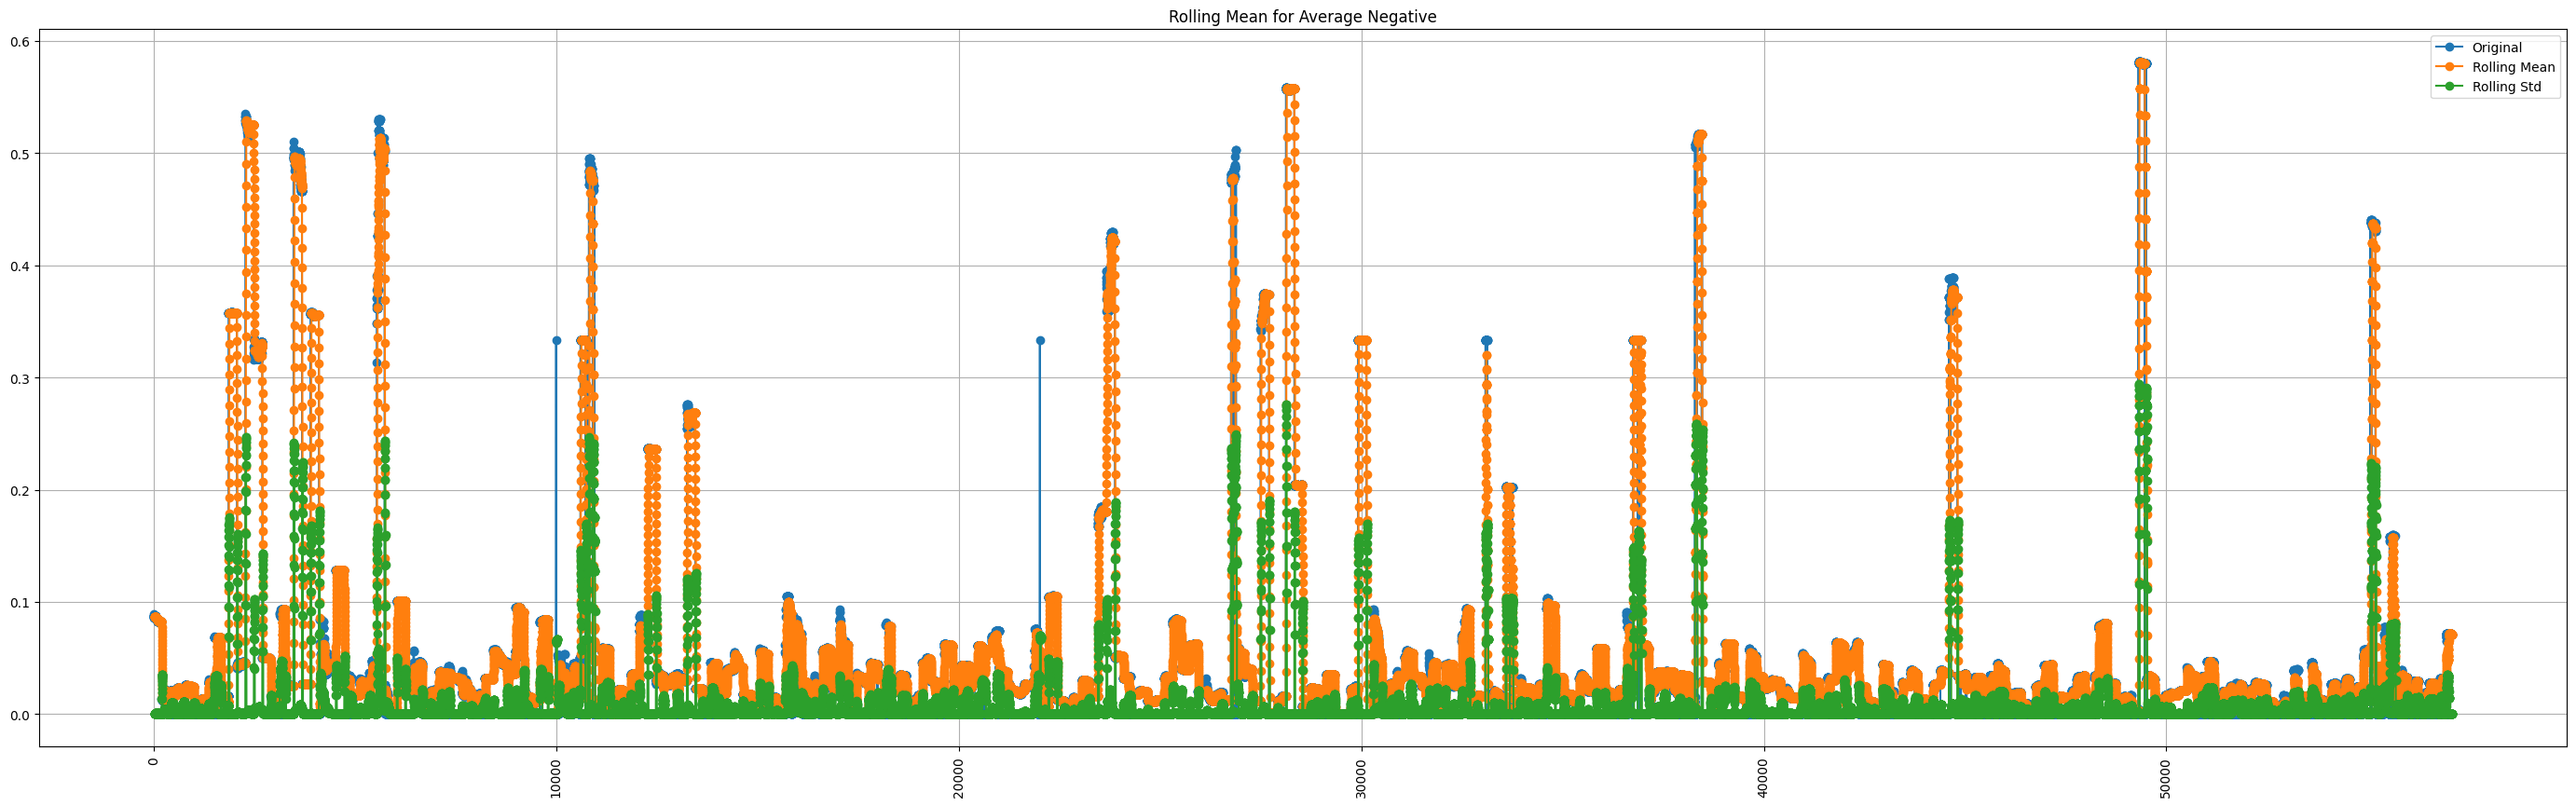

In [ ]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df['avg_neg'], marker='o', label='Original')
plt.plot(df['avg_neg'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(df['avg_neg'].rolling(window=25).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.title("Rolling Mean for Average Negative")
plt.legend()
plt.show()

## Stationary Check

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, signif=0.05, name='', verbose=False):


    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
# ADF Test on each column
for name, column in df.iteritems():
    check_stationarity(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "q_sold" 
    -----------------------------------------------
ADF Statistic: -20.841801
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "avg_neu" 
    -----------------------------------------------
ADF Statistic: -14.595511
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "avg_pos" 
    -----------------------------------------------
ADF Statistic: -16.785971
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "avg_neg" 
    -----------------------------------------------
ADF Statistic: -13.454296
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary




In [ ]:
# ADF Test on each column
for name, column in df.iteritems():
    check_stationarity(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "q_sold" 
    -----------------------------------------------
ADF Statistic: -20.841801
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "avg_neu" 
    -----------------------------------------------
ADF Statistic: -14.595511
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "avg_pos" 
    -----------------------------------------------
ADF Statistic: -16.785971
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "avg_neg" 
    -----------------------------------------------
ADF Statistic: -13.454296
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary




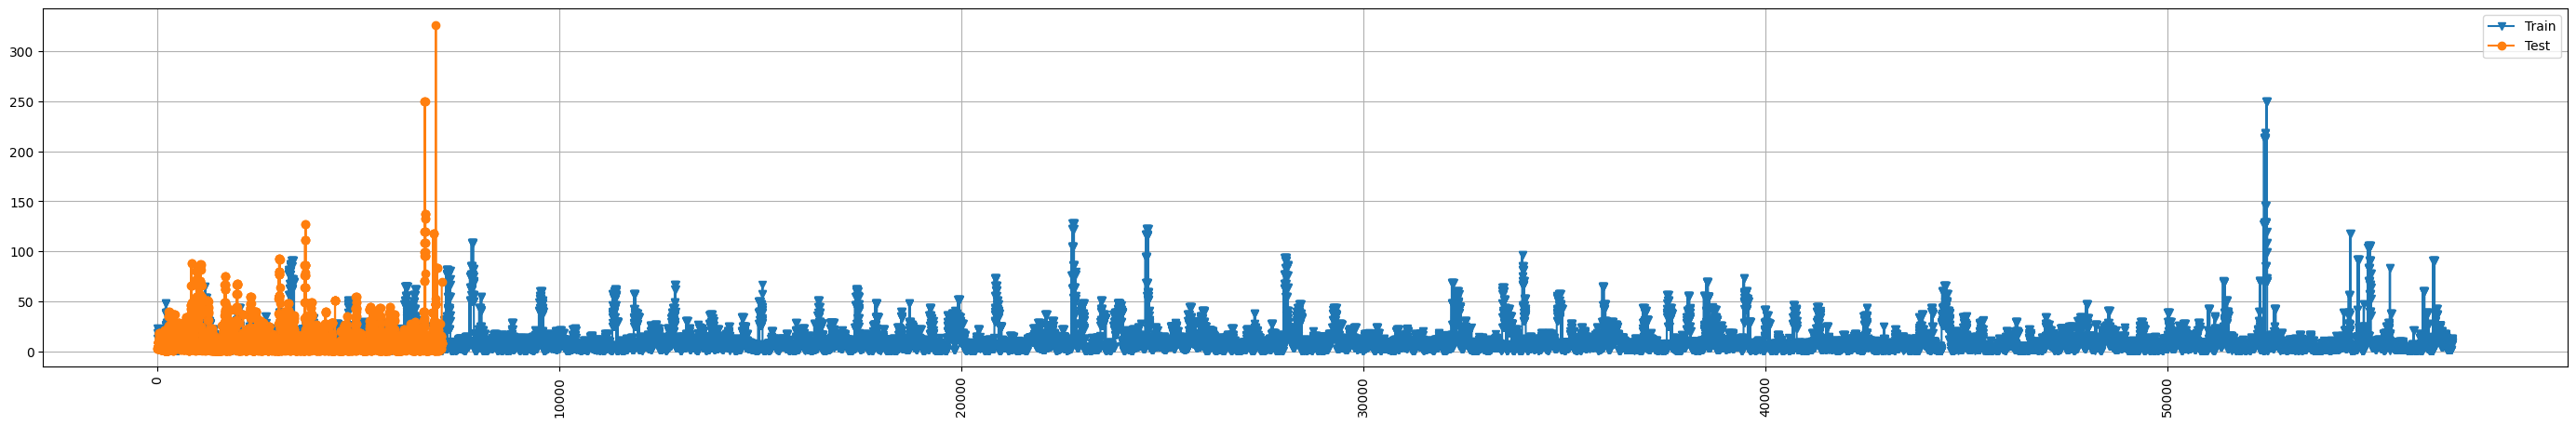

In [ ]:
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(df['q_sold'], marker='v', label='Train')
plt.plot(df_test['q_sold'], marker='o', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()

## Model-Fitting & Model Evaluation

In [ ]:
df = df.apply(pd.to_numeric, downcast='unsigned')

In [ ]:
import pmdarima as pm
import numpy as np

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=5.70 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=548.735, Time=0.07 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=526.244, Time=0.31 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.33 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=526.261, Time=0.15 sec
 ARIMA(1,2,0)(2,0,0)[4]             : AIC=526.860, Time=0.54 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=inf, Time=0.39 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=527.393, Time=0.38 sec
 ARIMA(1,2,0)(2,0,1)[4]             : AIC=inf, Time=0.79 sec
 ARIMA(0,2,0)(1,0,0)[4]             : AIC=550.206, Time=0.25 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=488.107, Time=0.55 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=490.695, Time=0.33 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=488.582, Time=0.83 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=489.550, Time=0.83 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=487.888, Time=0.80 se

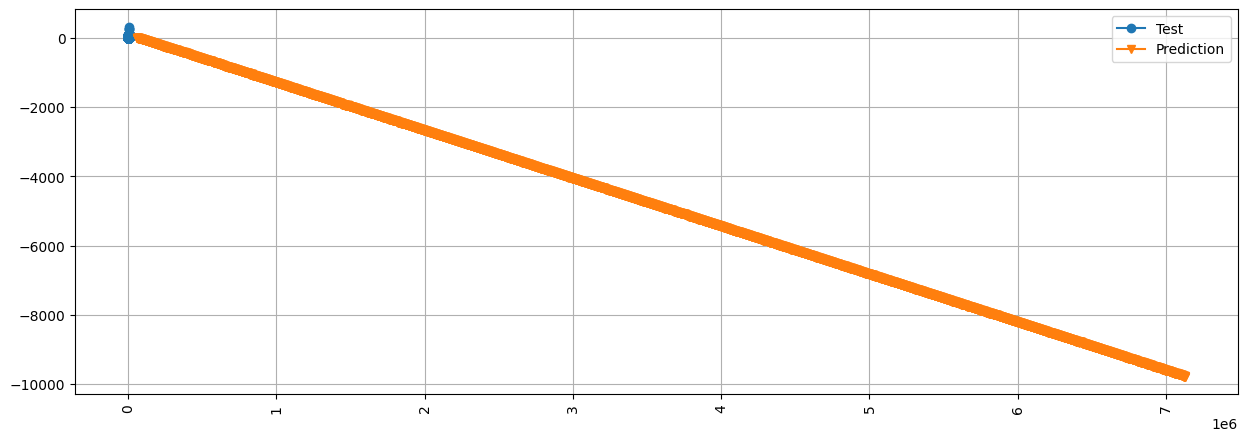

Mean Absolute Percentage Error 1150.1088635648211
Mean Squared Error 31960758.40504766
RMSE 5653.384685747792
AIC values 487.88841780374605


,Test,Prediction,Difference,% Change
0,3.000000,14.276512,-11.276512,375.883741
1,3.000000,10.133314,-7.133314,237.777142
2,4.000000,4.772858,-0.772858,19.321438
3,3.000000,10.395127,-7.395127,246.504226
4,6.000000,3.888428,2.111572,35.192866
...,...,...,...,...
7065,7.933333,-9783.251032,9791.184365,123418.289328
7066,7.933333,-9784.635882,9792.569215,123435.745421
7067,7.933333,-9786.020732,9793.954065,123453.201515
7068,7.933333,-9787.405582,9795.338915,123470.657608


In [ ]:
import torch

# Set the device to use for running PyTorch computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Set the device to use for running numpy/scipy computations
# if str(device) == 'cuda':
#     import numpy as np
#     import scipy as sp
#     np.cuda.set_device(device)
#     sp.cuda.set_device(device)
# Model Evaluation
# df = df[::10]

# Fit a simple auto_arima model
arima = pm.auto_arima(df['q_sold'],X=df.drop(columns=['q_sold']), d=2, seasonal=True,cache=False, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=500,m=4,stationary=False,test='adf')

# Print out summary information on the fit
print(arima.summary())
print(arima.params)



pred=arima.predict(n_periods=7070, X=df_test.drop(columns=['q_sold']), alpha=0.05)
pred

plt.figure(figsize=(15,5))
plt.grid()

plt.plot(df_test['q_sold'], marker='o', label='Test')
plt.plot(pred, marker='v', label='Prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()
print("="*50)
print("="*50)
mape=mean_absolute_percentage_error(df_test['q_sold'], pred)
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error(df_test['q_sold'], pred)
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("="*50)
print("AIC values {}".format(arima.aic()))
print("="*50)
print("="*50)
print("="*50)
print("="*50)


a=pd.DataFrame(df_test['q_sold'])
a=a.reset_index()
a=a.drop(columns='index')
a

prediction=pd.DataFrame(pred)
prediction=prediction.reset_index()
prediction=prediction.drop(columns='index')
prediction
output=pd.DataFrame()
output['Test']=a['q_sold']
output['Prediction']=prediction[0]
output['Difference']=output['Test']-output['Prediction']
output['% Change']=abs(output['Difference']/output['Test'])*100
output

In [ ]:
import torch

# Set the device to use for running PyTorch computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = df[::10]
# Model Evaluation

# Fit a simple auto_arima model
arima = pm.auto_arima(df['q_sold'],X=df.drop(columns=['q_sold']), d=1,seasonal=True, cache=False, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5000,m=4,stationary=False,test='adf')

# Print out summary information on the fit
print(arima.summary())
print(arima.params)



pred=arima.predict(n_periods=7070, X=df_test.drop(columns=['q_sold']), alpha=0.05)
pred

plt.figure(figsize=(15,5))
plt.grid()

plt.plot(df_test['q_sold'], marker='o', label='Test')
plt.plot(pred, marker='v', label='Prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()
print("="*50)
print("="*50)
mape=mean_absolute_percentage_error(df_test['q_sold'], pred)
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error(df_test['q_sold'], pred)
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("="*50)
print("MAE", mean_absolute_error(df_test['q_sold'], pred))
print("AIC values {}".format(arima.aic()))
print("="*50)
print("="*50)
print("="*50)
print("="*50)


a=pd.DataFrame(df_test['q_sold'])
a=a.reset_index()
a=a.drop(columns='index')
a

prediction=pd.DataFrame(pred)
prediction=prediction.reset_index()
prediction=prediction.drop(columns='index')
prediction
output=pd.DataFrame()
output['Test']=a['q_sold']
output['Prediction']=prediction[0]
output['Difference']=output['Test']-output['Prediction']
output['% Change']=abs(output['Difference']/output['Test'])*100
output

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=42197.601, Time=85.37 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=44058.601, Time=0.33 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=42448.838, Time=15.59 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=42380.838, Time=18.50 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=44056.601, Time=2.86 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=42201.263, Time=56.63 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=42201.260, Time=45.28 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=42158.387, Time=155.46 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=42167.192, Time=88.42 sec
 ARIMA(2,1,2)(2,0,2)[4] intercept   : AIC=42156.890, Time=219.16 sec
 ARIMA(2,1,2)(1,0,2)[4] intercept   : AIC=42160.369, Time=123.96 sec
 ARIMA(1,1,2)(2,0,2)[4] intercept   : AIC=42165.092, Time=112.60 sec
 ARIMA(2,1,1)(2,0,2)[4] intercept   : AIC=42156.058, Time=146.55 sec
 ARIMA(2,1,1)(1,0,2)[4] intercept   : AIC=42159.422, Time=117.01 sec
 

# **ARIMA**

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.pyplot as matplt
from tqdm import tqdm
from math import sqrt

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
X = df[['avg_neu','avg_pos', 'avg_neg']].values
# X = df['avg_pos'].values
y = df['q_sold'].values
model_arima = ARIMA(y, exog=X, order=(1,1,1))  # p,m,q: dieu chinh predict value vs data qk p: 1 value qk-> 1 value tuong lai
model = model_arima.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                57099
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -193685.138
Date:                Tue, 27 Jun 2023   AIC                         387382.276
Time:                        08:04:14   BIC                         387435.991
Sample:                             0   HQIC                        387398.999
                              - 57099                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2067      0.489     -0.423      0.672      -1.165       0.751
x2            -0.9917      0.152     -6.518      0.000      -1.290      -0.694
x3            -3.4756      1.192     -2.915      0.0

In [ ]:
X.shape

(57099, 3)

In [ ]:
y.shape

(57099,)

In [ ]:
import matplotlib.pyplot as plt
# using sentiment
# history_X = df[["avg_neu","avg_pos", "avg_neg"]].values.tolist()
# history_y = df['q_sold'].values
# test_X = df_test[["avg_neu","avg_pos", "avg_neg"]].values.tolist()
test_ = df_test["q_sold"].values.tolist()
predictions = list()
for index in tqdm(range(len(df_test))):
    model = ARIMA(y, exog=X, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.predict(exog=X_test)
    y_pred = output[0]
    predictions.append(y_pred)
    obs = test_[index]
    X = np.append(X, obs)
rmse = sqrt(mean_squared_error(test_, predictions))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(16,8))
plt.plot(df_test["Quantity sold"].reset_index(drop = True))
plt.plot(predictions, color='red')
plt.show()

  0%|          | 1/7070 [00:28<55:05:41, 28.06s/it]


ValueError: ignored

In [ ]:
print("R2 score  :", r2_score(test_, predictions))
print("MSE score  :", mean_squared_error(test_, predictions))
print("MAPE  :", mean_absolute_percentage_error(test_, predictions))
print("MAE score :", mean_absolute_error(test_, predictions))

In [ ]:
df['avg_neg']

0        0.088945
1        0.087291
2        0.086753
3        0.086753
4        0.086221
           ...   
57094    0.070744
57095    0.070635
57096    0.070635
57097    0.070635
57098    0.070635
Name: avg_neg, Length: 57099, dtype: float32

In [ ]:
X_train

array([[[19.        ,  0.18610506,  0.72495   ,  0.08894494],
        [23.        ,  0.18264259,  0.73006678,  0.08729062],
        [13.        ,  0.18151581,  0.73173166,  0.08675253],
        ...,
        [21.        ,  0.18040419,  0.73337476,  0.08622104],
        [17.        ,  0.17863093,  0.73405938,  0.08730968],
        [12.        ,  0.17863093,  0.73405938,  0.08730968]],

       [[23.        ,  0.18264259,  0.73006678,  0.08729062],
        [13.        ,  0.18151581,  0.73173166,  0.08675253],
        [15.        ,  0.18151581,  0.73173166,  0.08675253],
        ...,
        [17.        ,  0.17863093,  0.73405938,  0.08730968],
        [12.        ,  0.17863093,  0.73405938,  0.08730968],
        [16.        ,  0.17863093,  0.73405938,  0.08730968]],

       [[13.        ,  0.18151581,  0.73173166,  0.08675253],
        [15.        ,  0.18151581,  0.73173166,  0.08675253],
        [21.        ,  0.18040419,  0.73337476,  0.08622104],
        ...,
        [12.        ,  0.17

In [ ]:
import matplotlib.pyplot as plt

# not using sentiment

history = df["q_sold"].values.tolist()
test_ = df_test["q_sold"].values.tolist()
predictions = list()
for index in tqdm(range(len(df_test))):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output[0]
    predictions.append(y_pred)
    obs = test_[index]
    history.append(obs)
rmse = sqrt(mean_squared_error(test_, predictions))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(16,8))
plt.plot(df_test["Quantity sold"].reset_index(drop = True))
plt.plot(predictions, color='red')
plt.show()

In [ ]:
rmse = sqrt(mean_squared_error(test_, predictions))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(16,8))
plt.plot(df_test["Quantity sold"].reset_index(drop = True))
plt.plot(predictions, color='red')
plt.show()

In [ ]:
predictions = list()
print("R2 score  :", r2_score(test_, predictions))
print("MSE score  :", mean_squared_error(test_, predictions))
print("MAPE  :", mean_absolute_percentage_error(test_, predictions))
print("MAE score :", mean_absolute_error(test_, predictions))

In [ ]:
# predictions = list()
# test_item = []
# for item in range(1,df.Item.nunique()):
#     history = df[df["Item"] == item]["q_sold"].values.tolist()
#     test_ = df_test[df_test["Item"] == item]["q_sold"].values.tolist()
#     for index in range(len(test_)):
#          model = ARIMA(history, order=(1,1,1))
#          model_fit = model.fit()
#          output = model_fit.forecast()
#          y_pred = output[0]
#          predictions.append(y_pred)
#          obs = test_[index]
#          history.append(obs)
#     test_item.extend(test_)
#          # print('predicted=%f, expected=%f' % (y_pred, obs))

# rmse = sqrt(mean_squared_error(test_item, predictions))
# print("R2 score  :", r2_score(test_item, predictions))
# print("MSE score  :", mean_squared_error(test_item, predictions))
# print("MAPE  :", mean_absolute_percentage_error(test_item, predictions))
# print("MAE score :", mean_absolute_error(test_item, predictions))
# # print("MSLE score :", mean_squared_log_error(test_item, predictions))
# print('Test RMSE: %.3f' % rmse)

# plt.figure(figsize=(16,8))
# plt.plot(df_test["q_sold"].reset_index(drop = True))
# plt.plot(predictions, color='red')
# plt.show()

In [ ]:
# Make predictions
X_test = df_test[['avg_neu','avg_neg','avg_pos']].values
y_pred = model_fit.predict(exog=X_test)

# Print actual and predicted demand values
print('Actual:', df_test['q_sold'].values)
print('Predicted:', y_pred)

Actual: [ 3.         3.         4.        ...  7.9333334  7.9333334 70.       ]
Predicted: [ 0.         18.99934435 21.2621984  ...  7.00978842  6.50741468
  7.24623257]


In [ ]:
# predictions = list()
print("R2 score  :", r2_score(X_test,y_pred))
print("MSE score  :", mean_squared_error(X_test, y_pred))
print("MAPE  :", mean_absolute_percentage_error(X_test, y_pred))
print("MAE score :", mean_absolute_error(X_test, y_pred))

# LSTM

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Reshape, Dropout, Dense,Multiply, Dot, Concatenate, Embedding, Flatten
from tensorflow.keras.models import load_model

from tensorflow.python import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from keras.metrics import Metric

In [ ]:
### Design API for custom LSTM model - 2023/03/14

class LSTM_model:

  def __init__(self,x_train=[], y_train=[], x_test=[], y_test=[], num_LSTM=[128,64], dropout_value = 0, mlp_num=[20,10,1], epochs=10,
               batch_size=16, input_shape=(9,1), loss='mse', optimizer='adam',
               metrics = 'mean_squared_error', patience_num=3, show_progress=True):
    self.num_LSTM = num_LSTM
    self.dropout_value = dropout_value
    self.mlp_num = mlp_num
    self.epochs = epochs
    self.batch_size = batch_size
    self.input_shape = input_shape
    self.loss = loss
    self.optimizer = optimizer
    self.metrics = metrics
    self.patience_num = patience_num
    self.show_progress = show_progress
    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test

    if (len(self.x_train)==0):
      raise Exception("Please input the train data")
    if (len(self.y_train)==0):
      raise Exception ("Please input the label train data")

    self.lstm_model = Sequential()
    if len(self.num_LSTM) > 1:
      for i in self.num_LSTM:
        self.lstm_model.add(LSTM(i, input_shape=self.input_shape, return_sequences=True))
    else:
      self.lstm_model.add(LSTM(self.num_LSTM[0], input_shape=self.input_shape))
    self.lstm_model.add(Flatten())
    for i in self.mlp_num:
      self.lstm_model.add(Dropout(self.dropout_value))
      self.lstm_model.add(Dense(i, activation='relu'))

  def print_model_architecture(self):
    self.lstm_model.summary()

  def train_model(self):
    # callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.patience_num)

    # model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    # filepath='./ckpt/sentiment',
    # save_weights_only=False,
    # monitor='val_loss',
    # mode='min',
    # save_best_only=True)
    callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_lstm.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.00001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

    self.lstm_model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics, run_eagerly=True)
    # history = self.lstm_model.fit(self.x_train, self.y_train, validation_data=(self.x_test, self.y_test), batch_size= self.batch_size, epochs=self.epochs, callbacks=callbacks, verbose=self.show_progress)
    NORMALIZED_FACTOR = np.max(X_train, axis=0)
    print(NORMALIZED_FACTOR.shape)
    history = self.lstm_model.fit(
        self.x_train/NORMALIZED_FACTOR,
        self.y_train/NORMALIZED_FACTOR[0,0],
    # X_train,
    # Y_train,
        batch_size=self.batch_size,
        epochs=self.epochs,
        callbacks=callbacks,
        validation_data=(self.x_test/NORMALIZED_FACTOR, self.y_test/NORMALIZED_FACTOR[0,0]),
    # validation_data=(X_test, Y_test),
        verbose=1,
)

    return self.lstm_model, history


  def predict(self,X_test):
    return self.lstm_model.predict(X_test)

# X_train, y_train, X_test, y_test = split(df, method='by_date', regressor=True, sentiment=True, rating=False, n = 1)
# X_train, Y_train, dates_train, X_test, Y_test, dates_test = train_test_split(X_data, Y_data, dates_data, start_test_date)
lstm_model = LSTM_model(x_train=X_train, y_train=Y_train, x_test=X_test, y_test=Y_test, num_LSTM=[16, 32], dropout_value = 0.1, mlp_num=[16,8,1], epochs=100,
               batch_size=32, input_shape=(X_train[0].shape), loss='mse', optimizer='adam',
               metrics = [tf.keras.metrics.RootMeanSquaredError(),
              tf.keras.metrics.MeanSquaredError(),
              tf.keras.metrics.MeanAbsoluteError(),
            #  keras.metrics.PrecisionAtRecall(recall=0.5, name='r0.5'),
            #  DailySalesMetric(),
            #  r1_metric
            ], patience_num=10, show_progress=True)

lstm_model.print_model_architecture()
model, hist = lstm_model.train_model()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 7, 16)             1344      
                                                                 
 lstm_19 (LSTM)              (None, 7, 32)             6272      
                                                                 
 flatten_8 (Flatten)         (None, 224)               0         
                                                                 
 dropout_24 (Dropout)        (None, 224)               0         
                                                                 
 dense_24 (Dense)            (None, 16)                3600      
                                                                 
 dropout_25 (Dropout)        (None, 16)                0         
                                                                 
 dense_25 (Dense)            (None, 8)               

In [ ]:
NORMALIZED_FACTOR = np.max(X_train, axis=0)
print(NORMALIZED_FACTOR.shape)

(7, 4)


In [ ]:
print(min(hist.history['val_mean_squared_error']) * NORMALIZED_FACTOR[0,0])
print(min(hist.history['val_mean_absolute_error'])* NORMALIZED_FACTOR[0,0])
print(min(hist.history['val_root_mean_squared_error'])* NORMALIZED_FACTOR[0,0])
# print(max(hist.history['val_r2_score']))

0.6879559461958706
4.813992515206337
12.13353105634451
